# Bias Detection #

This experiment explores the bias introduced to machine learning models due to bias in the dataset. Bias can be characterized from three concepts (1) what actions (2) in which situations (3) towards whom are considered discriminatory [Zliobaite 2015]. This experiment aims to focus on (2) situation induced bias. 

We will be using resnet, an object detection model, and compare its validation accuracy during day time versus during night time. We create three different training data sets and train the resnet into three different models. The first dataset contains mainly images in night time, the second contains mainly images in day time, and the third contains equal images from day and night time. 

Each model is trained until it reaches at least 18.5% accuracy on its validation set. We made sure the validation set has the same distribution as its training data set. We then calculate the bias magnitutude using normalized difference and stratefied difference on the test dataset. The test dataset is the same on all models

## Import Libraries ##

In [1]:
import tensorflow as tf
import os
import sys
sys.path.append("..")
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import IPython.display as dp
import cv2
import json
from pprint import pprint
import tutorial_util as utils

/home/cstseng/Documents/algoFairness_ww40.2/tutorial


In [2]:
%matplotlib inline

### Display Training Data Statistics ###

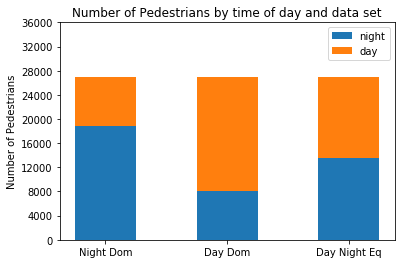

In [36]:
N = 3
night_person = (18898, 8089, 13497)
day_person = (8092, 18898, 13498)
ind = np.arange(N)

pnight = plt.bar(ind, night_person, width=0.5)
pday = plt.bar(ind, day_person , width=0.5, bottom=night_person)

plt.ylabel('Number of Pedestrians')
plt.title('Number of Pedestrians by time of day and data set')
plt.xticks(ind, ('Night Dom', 'Day Dom', 'Day Night Eq'))
plt.yticks(np.arange(0, 38000, 4000))
plt.legend((pnight[0], pday[0]), ('night', 'day'))

plt.show()

## Define Local Variables ##

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/strata-bias-data/inputdata.tar.gz

In [3]:
# contains test images
inputdir = 'inputdata'
outputdir = 'outputdata'
inputdata = glob.glob(inputdir + '/*jpg')

In [4]:
# models trained on 3 different training sets using the same type of model
NIGHT_DOM_FROZEN_GRAPH_PATH = '../night_dom_inference/frozen_inference_graph.pb'
DAY_DOM_FROZEN_GRAPH_PATH = '../daydom_10000_inference/frozen_inference_graph.pb'
DAYNIGHT_EQ_FROZEN_GRAPH_PATH = '../daynight_15000_inference/frozen_inference_graph.pb'

## Process GroundTruth Labels ##

In [5]:
# Read original BDD val labels and only select labels with pedestrians
with open('val_labels.json') as f:
    val_raw_labels = json.load(f)
    gt = utils.proc_gt(val_ral_labels)

### Display Original Image ###

We randomly select two images, one from day, one from night to demonstrate our experiment. 
How many pedestrians can you spot in each image?

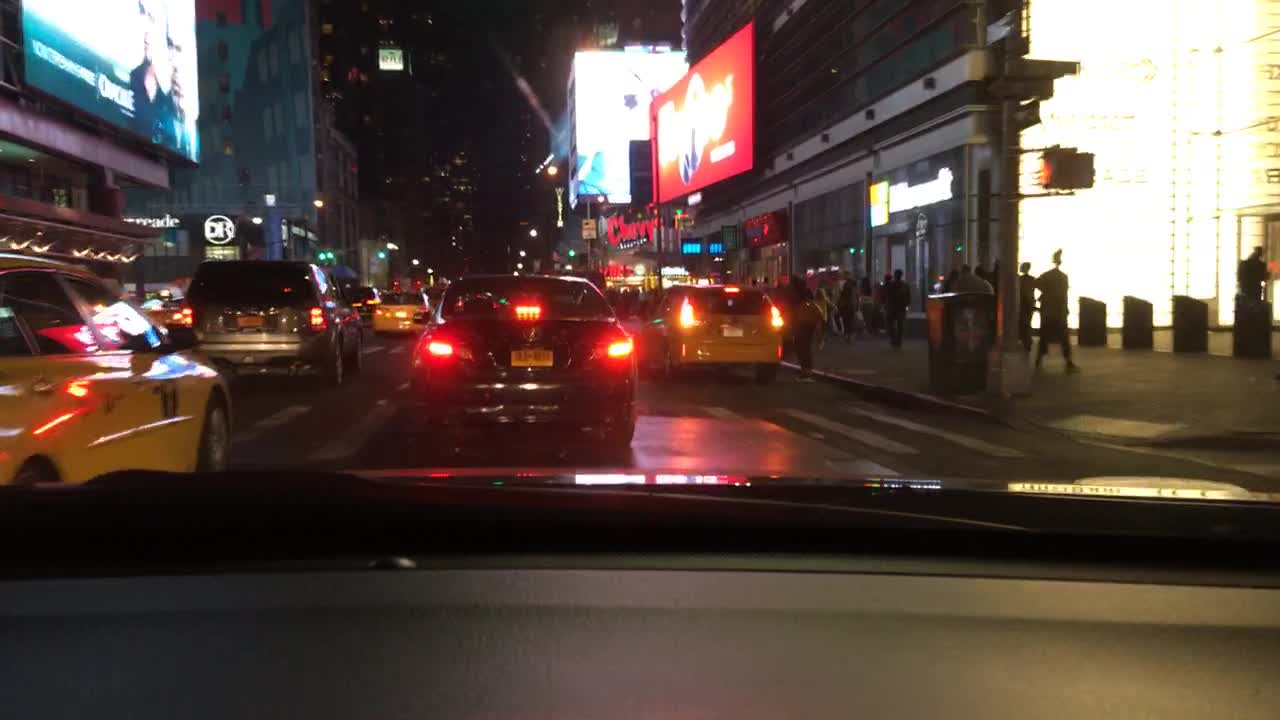

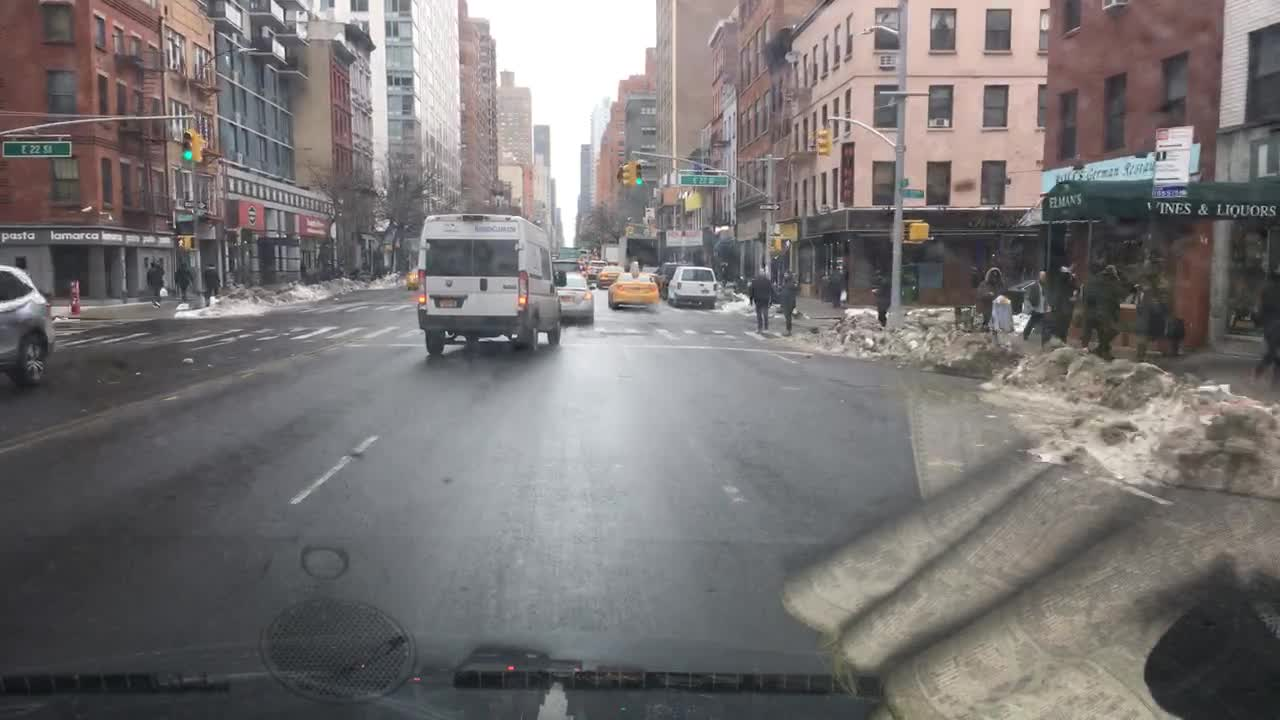

In [6]:
for img_path in inputdata:
    obj = dp.Image(filename=img_path)
    dp.display(obj)

Groundtruth image b1ca2e5d-84cf9134.jpg has 18 Number of pedestrians


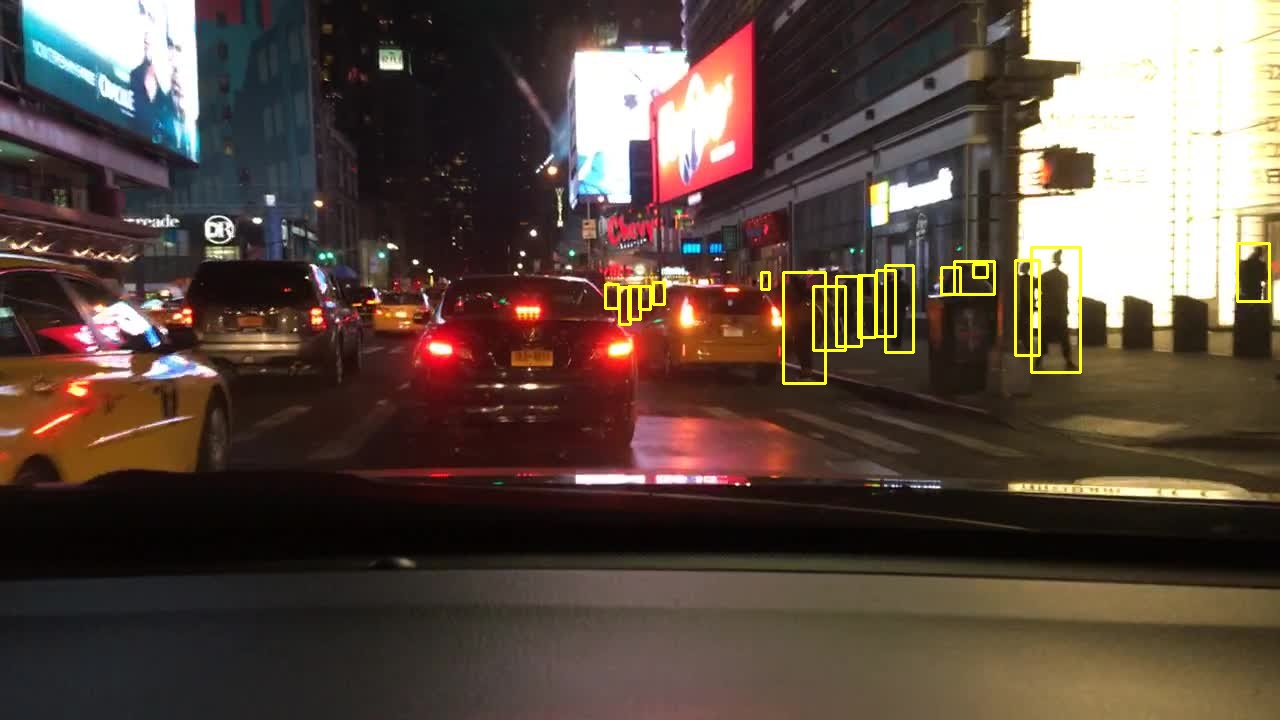

Groundtruth image b1d0a191-03dcecc2.jpg has 13 Number of pedestrians


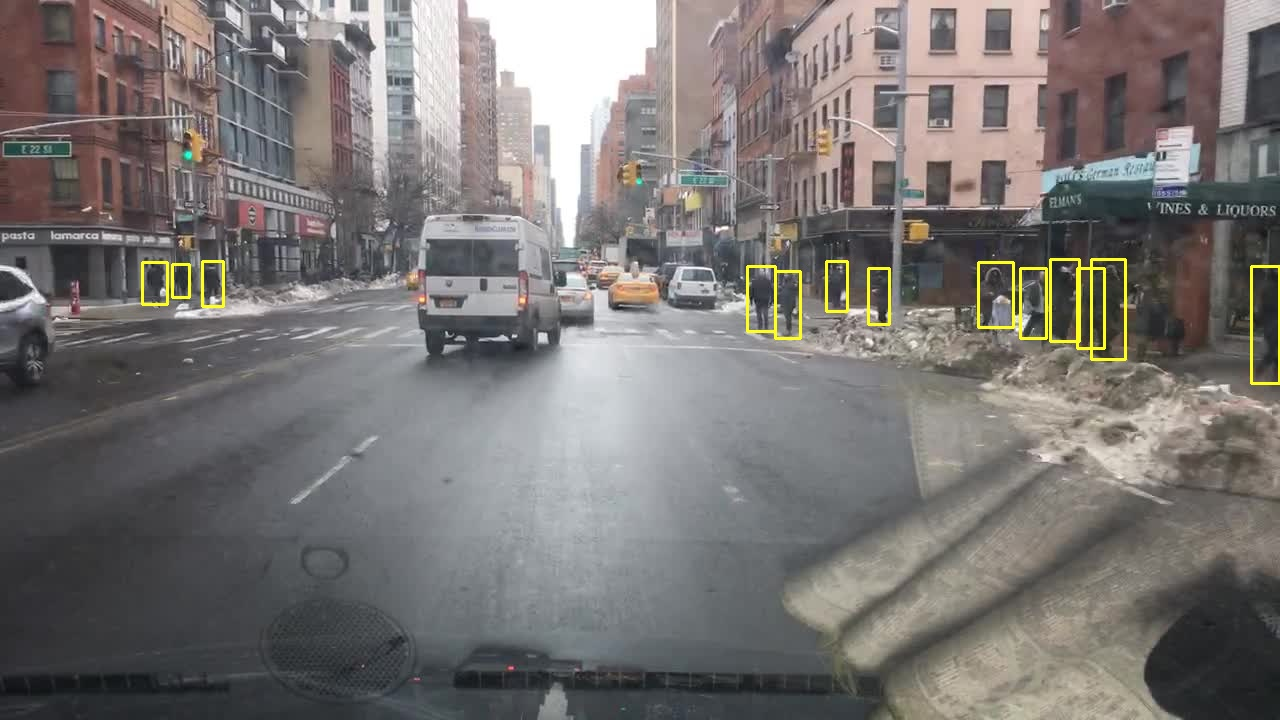

In [38]:
for gt_img in gt:
    # open image
    filename = gt_img['name']
    img_path = inputdir + '/' + filename
    img = cv2.imread(img_path)

    # draw groundtruth rectangles on each image
    gt_img_path = outputdir + '/gt_' + filename
    for i, classval in enumerate(gt_img['classes']):
        cv2.rectangle(img, (int(gt_img['bbox_xmin'][i]), int(gt_img['bbox_ymin'][i])), (int(gt_img['bbox_xmax'][i]), int(gt_img['bbox_ymax'][i])), (30, 255, 255), thickness=2)
    cv2.imwrite(gt_img_path, img)
    print("Groundtruth image", filename, "has", len(gt_img['classes']), "Number of pedestrians")
    dp_gt_img = dp.Image(filename=gt_img_path, format='jpg')
    dp.display(dp_gt_img)

Were you able to identify them all?

## Run Inference ##

Now let's see how well our three models perform on the test images. First we will pick the model trained on night dominated training set

### Run Inference on Night Dominated Model ###

In [7]:
night_detection_result = utils.run_inference_show_bbox(NIGHT_DOM_FROZEN_GRAPH_PATH, inputdir, outputdir, 'nightdom')

b1ca2e5d-84cf9134.jpg Number of detected pedestrians 14
b1d0a191-03dcecc2.jpg Number of detected pedestrians 17


Let's visually inspect these detections

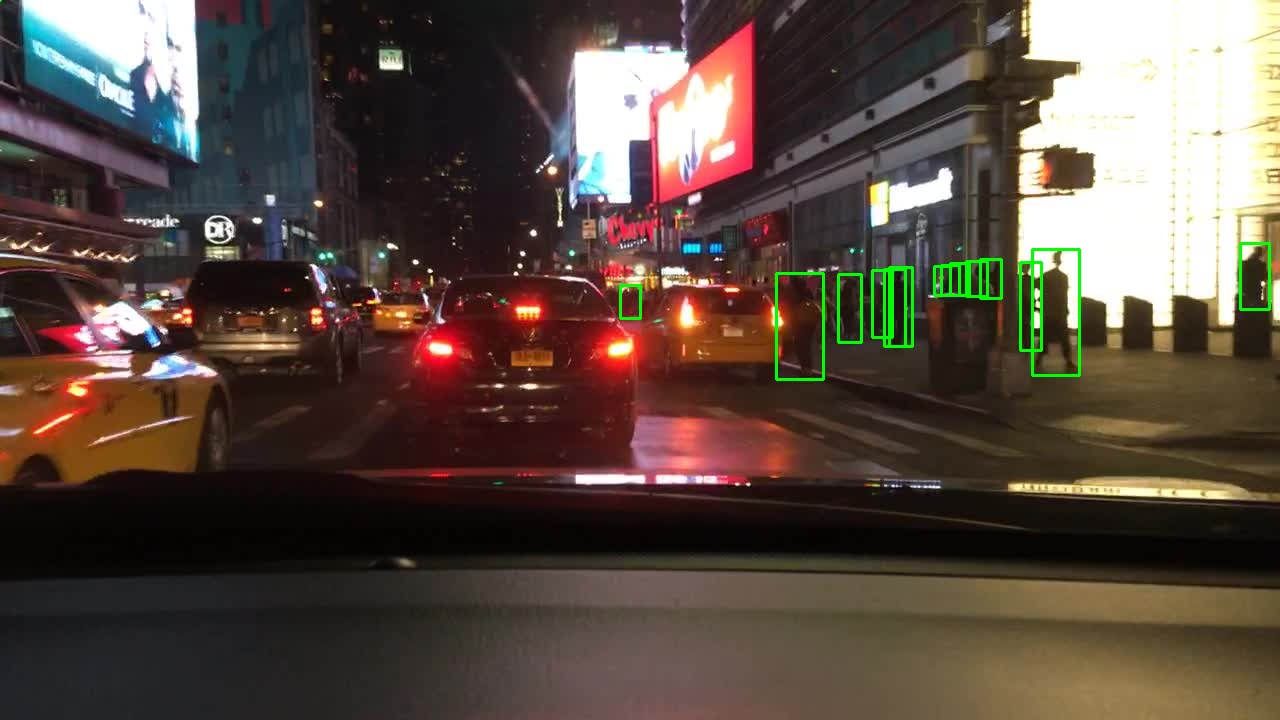

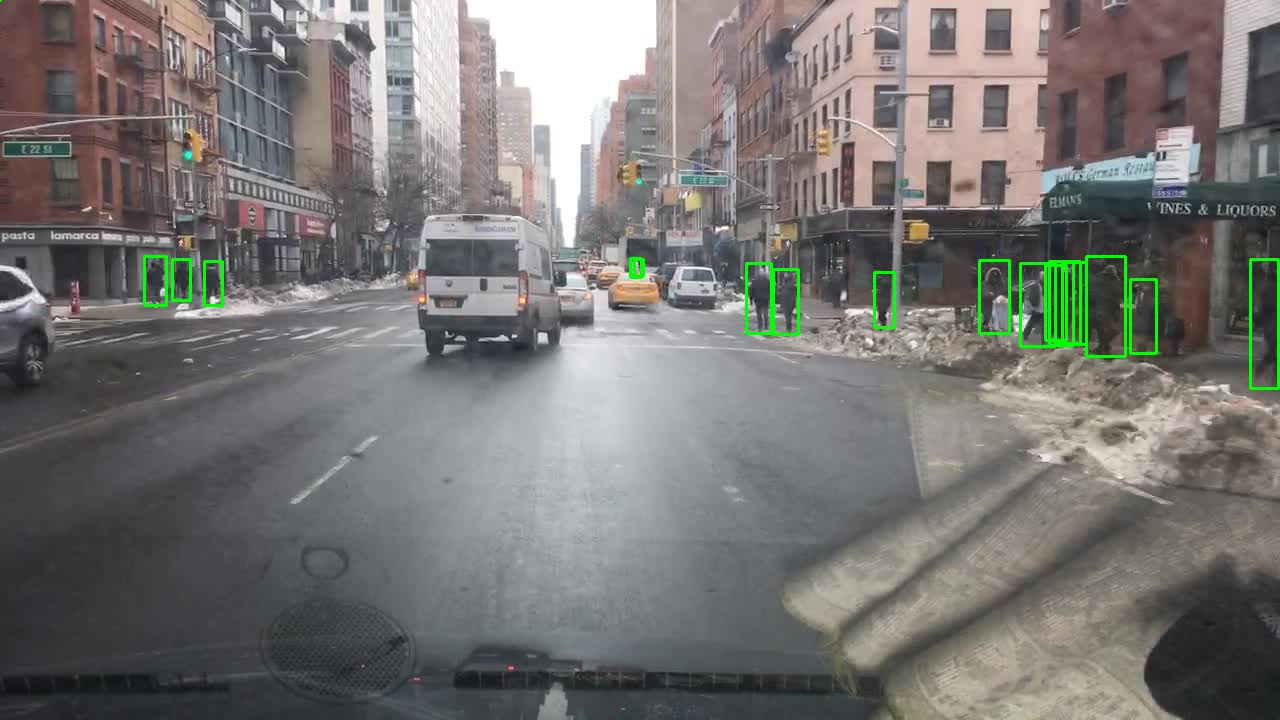

In [42]:
night_det_images = glob.glob(outputdir + '/det_nightdom*')
for img_path in night_det_images:
    #filename = night_det_img['name']
    # display detected image
    #print("Detection image", filename, "has", len(night_det_img['classes']), "Number of pedestrians")
    dp_det_img = dp.Image(filename=img_path, format='jpg')
    dp.display(dp_det_img)

       

For night time, the night dominated model detected 14 out of 18.
For day time, the night dominated model detected 17 out of 13

Overall it did pretty well on detecting pedestrians at night, but during day time it was having trouble distinguishing pedestrians that are do not have a full view (occluded).

## Calculate Bias Magnitude ##

### Calculate Recall at Night vs Day ###

In [44]:
threshold = 0.75 # BDD dataset's IOU threshold is 0.75, we will use the same
night_recall, night_tp, night_gt = utils.get_confusion(gt[0], night_detection_result[0], threshold)
print("Night Recall", night_recall)

day_recall, day_tp, day_gt = utils.get_confusion(gt[1], night_detection_result[1], threshold)
print("Day Recall", day_recall)

Night Recall 0.2777777777777778
Day Recall 0.6923076923076923


### Mean Difference ###

$$ d = p(y^+ | s^0) - p(y^+ | s^1)$$

In [45]:
# normalized difference
def mean_diff(grp0_recall, grp1_recall):
    """Typically grp1 is the protected group
    """
    return grp0_recall - grp1_recall

In [46]:
nightdom_mdiff = mean_diff(day_recall, night_recall)
print("Mean difference", nightdom_mdiff)

Normalized difference 0.4145299145299145


We see that there is significant difference betweeen the recall of day vs night. 
However is this a fair comparison? Recall that the day image had a lot of occluded (cluttered) pedestrians. Is there a way to take this into account so our bias measurement is fair?

Before we were simply comparing recall between day vs now. Now we want to compare recalls under the same condition. 

That is:

1. compare recall at night vs recall at day when pedestrians are not occluded
2. Compare recall at night vs recall at day when pedestrians are occluded

This is call stratification

In [12]:
def stratify(gt, attribute):
    """Split gt based on attribute """
    attr_vals = np.unique(gt[attribute])
    gt_strat = {}
    
    for attr_val in attr_vals:
        gt_strat[attr_val] = {}
        attr_idx = [i for i, e in enumerate(gt[attribute]) if e == attr_val ]
        #print("Attribute val", attr_val, "attr idx", attr_idx)
        gt_strat[attr_val]['bbox_xmin'] = [gt['bbox_xmin'][i] for i in attr_idx]
        gt_strat[attr_val]['bbox_ymin']  = [gt['bbox_ymin'][i] for i in attr_idx]
        gt_strat[attr_val]['bbox_xmax']  = [gt['bbox_xmax'][i] for i in attr_idx]
        gt_strat[attr_val]['bbox_ymax']  = [gt['bbox_ymax'][i] for i in attr_idx]
        gt_strat[attr_val]['classes']  = [gt['classes'][i] for i in attr_idx]

    return gt_strat, attr_vals



In [47]:
# In this case the attribute we want to stratify is occluded or not occluded
# we stratify each image
gt_night_strat, night_attr_vals = stratify(gt[0], 'occluded')
gt_day_strat, day_attr_vals = stratify(gt[1], 'occluded')

# let's look at what the data looks like after stratification, noticed there are only 3 persons not occluded
print("Original GroundTruth at night")
pprint(gt[0])

# notice here the number of classes under false (number of person not occluded) is exactly 3
print("Stratified GroundTruth at night")
pprint(gt_night_strat)

Original GroundTruth at night
{'bbox_xmax': [618.211911,
               630.453731,
               650.040643,
               640.247186,
               664.730827,
               845.093693,
               861.008058,
               875.698242,
               895.285153,
               987.098805,
               994.443896,
               960.1668,
               1039.738629,
               769.19437,
               825.506742,
               913.647884,
               1080.544672,
               1269.0687],
 'bbox_xmin': [605.970091,
               619.436093,
               639.023005,
               628.005367,
               653.713189,
               813.264961,
               836.524419,
               858.559694,
               876.922423,
               973.632802,
               954.04589,
               941.80407,
               1015.25499,
               761.849278,
               783.884554,
               885.491697,
               1031.577392,
               1237.239968]

### Calculate Unexplained Difference ###

$$ d_e = \sum^{m}_{i=1} p^*(y^+ | z^i)(p(z^i|s^0) - p(z^i|s^1)$$
$$p*(y^+ | z^i) = \frac{p(y^+|s^0, z^i) + p(y^+|s^1, z^i)}{2}$$

In [49]:
# calculate recall for occluded/non-occluded at day/night
def calc_unexp_diff(gt_night_strat, gt_day_strat, gt, detection_result, threshold):
    # calculate probability of person being occluded
    prob_occlude_night = len(gt_night_strat[True]['classes'])/len(gt[0]['classes'])
    prob_occlude_day = len(gt_day_strat[True]['classes'])/len(gt[1]['classes'])

    prob_nonocc_night = len(gt_night_strat[False]['classes'])/len(gt[0]['classes'])
    prob_nonocc_day = len(gt_day_strat[False]['classes'])/len(gt[1]['classes'])

    occluded_night_recall, occ_night_tp, night_occ_gt = utils.get_confusion(gt_night_strat[True], detection_result[0], threshold)
    nonocc_night_recall, nonocc_night_tp, night_nonocc_gt = utils.get_confusion(gt_night_strat[False], detection_result[0], threshold)
    occluded_day_recall, occ_day_tp, day_occ_gt = utils.get_confusion(gt_day_strat[True], detection_result[1], threshold)
    nonocc_day_recall, nonocc_day_tp, day_nonocc_gt  = utils.get_confusion(gt_day_strat[False], detection_result[1], threshold)

    occ_recall = (occluded_night_recall + occluded_day_recall)/2
    nonocc_recall = (nonocc_night_recall + nonocc_day_recall)/2

    unexp_diff = occ_recall * (prob_occlude_day - prob_occlude_night) + nonocc_recall * (prob_nonocc_day - prob_nonocc_night)
    return unexp_diff

In [51]:
# calculate unexplained difference
nightdom_unexp_diff = calc_unexp_diff(gt_night_strat, gt_day_strat, gt, night_detection_result, threshold)
print("Unexplained Difference", nightdom_unexp_diff)

Unexplained Difference 0.10741758241758245


### Run Inference for day dominated model ###

In [52]:
day_detection_result = utils.run_inference_show_bbox(DAY_DOM_FROZEN_GRAPH_PATH, inputdir, outputdir, 'daydom')

b1ca2e5d-84cf9134.jpg Number of detected pedestrians 6
b1d0a191-03dcecc2.jpg Number of detected pedestrians 17


In [53]:
daydom_night_recall, _, _ = utils.get_confusion(gt[0], day_detection_result[0], threshold)
print("Night Recall", daydom_night_recall)

daydom_day_recall, _, _ = utils.get_confusion(gt[1], day_detection_result[1], threshold)
print("Day Recall", daydom_day_recall)



Night Recall 0.2777777777777778
Day Recall 0.46153846153846156


In [54]:
daydom_norm_diff = norm_diff(daydom_day_recall, daydom_night_recall)
print("Mean difference", daydom_norm_diff)
daydom_unexp_diff = calc_unexp_diff(gt_night_strat, gt_day_strat, gt, day_detection_result, threshold)
print("Unexplained Difference", daydom_unexp_diff)

Normalized difference 0.39814814814814814
Unexplained Difference 0.18394383394383398


### Run Inference on Day Night Equal Model ###

In [55]:
daynight_detection_result = utils.run_inference_show_bbox(DAYNIGHT_EQ_FROZEN_GRAPH_PATH, inputdir, outputdir, 'daynight')
daynight_night_recall, _, _ = utils.get_confusion(gt[0], daynight_detection_result[0], threshold)
print("Night Recall", daynight_night_recall)

daynight_day_recall, _, _ = utils.get_confusion(gt[1], daynight_detection_result[1], threshold)
print("Day Recall", daynight_day_recall)


b1ca2e5d-84cf9134.jpg Number of detected pedestrians 8
b1d0a191-03dcecc2.jpg Number of detected pedestrians 14
Night Recall 0.2777777777777778
Day Recall 0.38461538461538464


In [57]:
daynight_norm_diff = norm_diff(daynight_day_recall, daynight_night_recall)
print("Mean difference", daynight_norm_diff)
daynight_unexp_diff = calc_unexp_diff(gt_night_strat, gt_day_strat, gt, daynight_detection_result, threshold)
print("Unexplained Difference", daynight_unexp_diff)

Mean difference 0.2777777777777778
Unexplained Difference 0.11373626373626375


## Summary ##

## References ##
survey of indirect discrimination in machine learning